In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf 
from tensorflow import keras

2024-08-03 16:30:59.330890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 16:30:59.331046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 16:30:59.489317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = '/kaggle/input/landscape-image-colorization/landscape Images'

In [3]:
# Reading image and saving it into arrays 
c_list = os.listdir(path+'/color')

In [4]:
b_list = os.listdir(path+'/gray')

In [5]:
import cv2
from tqdm import tqdm

In [6]:
color =[]
bw=[]

In [7]:
for pic in tqdm(c_list):
    img = cv2.imread(path+'/color/'+pic)
    img = cv2.resize(img,(128,128))
    img = img/255
    color.append(img)


100%|██████████| 7129/7129 [01:03<00:00, 111.45it/s]


In [8]:
color[1].shape

(128, 128, 3)

In [9]:
for pic in tqdm(b_list):
    img = cv2.imread(path+'/gray/'+pic)
    img = cv2.resize(img,(128,128))
    img = img/255
    bw.append(img)

100%|██████████| 7129/7129 [01:00<00:00, 117.02it/s]


In [10]:
bw[1].shape

(128, 128, 3)

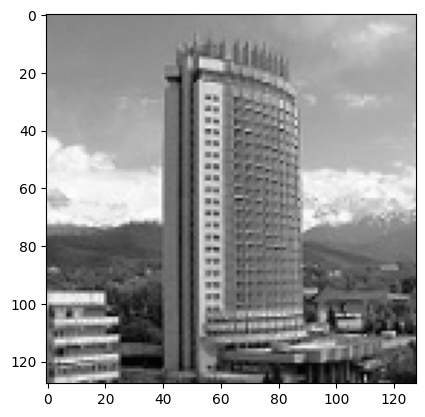

In [11]:
##seeing the pictures loaded 
plt.imshow(bw[-1])


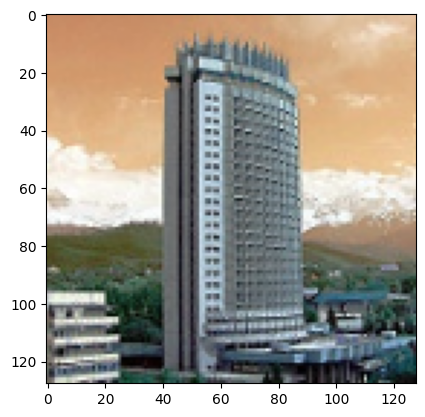

In [12]:
plt.imshow(color[-1])

In [13]:
from tensorflow.keras.models import Model

In [14]:
from tensorflow.keras.layers import *

# WE WILL USE GAN TO TRAIN MODEL TO PREDICT COLORS OF THE IMAGE 

## Generator model
### To generate images that are clored while taking input of a b/w image 

In [15]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=(  128, 128 , 3 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


## Descriminator model 
### to predict if the image is fake or real

In [16]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 128 , 128 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model

In [17]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError  
from tensorflow.keras.optimizers import Adam

In [18]:
## defining loss and optimizers 
cross_entropy = BinaryCrossentropy()
mse = MeanSquaredError()
gen_optimizer = Adam(learning_rate=0.0005)
dis_optimizer = Adam(learning_rate=0.0005)


In [19]:
dis_model = get_discriminator_model()
gen_model = get_generator_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
gen_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 124, 124,  │      1,216 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 124, 124,  │          0 │ conv2d_8[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 122, 122,  │      4,640 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 122, 122,  │          0 │ conv2d_9[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 120, 120,  │      9,248 │ leaky_re_lu_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 120, 120,  │          0 │ conv2d_10[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 116, 116,  │     25,632 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 116, 116,  │          0 │ conv2d_11[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 114, 114,  │     18,496 │ leaky_re_lu_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 114, 114,  │          0 │ conv2d_12[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 112, 112,  │     36,928 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 112, 112,  │          0 │ conv2d_13[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 108, 108,  │    102,464 │ leaky_re_lu_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 108, 108,  │          0 │ conv2d_14[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 106, 106,  │     73,856 │ leaky_re_lu_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 106, 106,  │          0 │ conv2d_15[0][0] 

 Total params: 1,407,203 (5.37 MB)

 Trainable params: 1,407,203 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
dis_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 122, 122, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 116, 116, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 54, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,563,265 (9.78 MB)

 Trainable params: 2,563,265 (9.78 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

In [23]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = gen_model( input_x , training=True)
        
        real_output = dis_model( real_y, training=True)
        
        generated_output = dis_model(generated_images, training=True)
        
        
        gen_loss = generator_loss( generated_images , real_y )
        
        disc_loss = discriminator_loss( real_output, generated_output )
        
    
    

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_model.trainable_variables)

    # Optimize with Adam
    gen_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))
    
    
gen_model.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

dis_model.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)

In [24]:
dataset = tf.data.Dataset.from_tensor_slices( ( bw , color ) )
dataset = dataset.batch( 64 )

In [55]:
num_epochs = 100

for e in range( num_epochs ):
    print( e )
    for ( x , y ) in tqdm(dataset):
        train_step( x , y )

0


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


1


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


2


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


3


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


4


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


5


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


6


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


7


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


8


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


9


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


10


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


11


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


12


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


13


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


14


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


15


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


16


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


17


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


18


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


19


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


20


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


21


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


22


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


23


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


24


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


25


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


26


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


27


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


28


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


29


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


30


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


31


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


32


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


33


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


34


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


35


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


36


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


37


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


38


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


39


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


40


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


41


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


42


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


43


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


44


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


45


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


46


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


47


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


48


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


49


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


50


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


51


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


52


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


53


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


54


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


55


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


56


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


57


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


58


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


59


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


60


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


61


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


62


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


63


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


64


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


65


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


66


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


67


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


68


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


69


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


70


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


71


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


72


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


73


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


74


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


75


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


76


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


77


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


78


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


79


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


80


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


81


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


82


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


83


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


84


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


85


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


86


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


87


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


88


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


89


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


90


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


91


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


92


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


93


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


94


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


95


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


96


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


97


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


98


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


99


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


In [83]:
for e in range( 50 ):
    print( e )
    for ( x , y ) in tqdm(dataset):
        train_step( x , y )

0


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


1


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


2


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


3


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


4


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


5


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


6


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


7


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


8


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


9


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


10


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


11


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


12


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


13


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


14


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


15


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


16


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


17


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


18


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


19


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


20


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


21


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


22


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


23


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


24


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


25


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


26


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


27


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


28


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


29


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


30


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


31


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


32


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


33


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


34


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


35


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


36


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


37


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


38


100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


39


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


40


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


41


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


42


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


43


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


44


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


45


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


46


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


47


100%|██████████| 112/112 [01:11<00:00,  1.58it/s]


48


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


49


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


In [57]:
import matplotlib.pyplot as plt

In [58]:
y = bw[10]

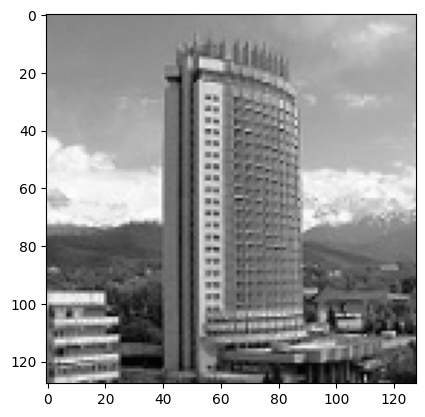

In [84]:
plt.imshow(bw[-1])

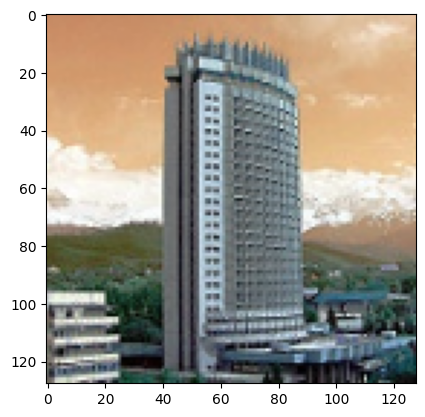

In [68]:
plt.imshow(color[-1])

In [85]:
predict = gen_model.predict(bw[-1].reshape(1,128,128,3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


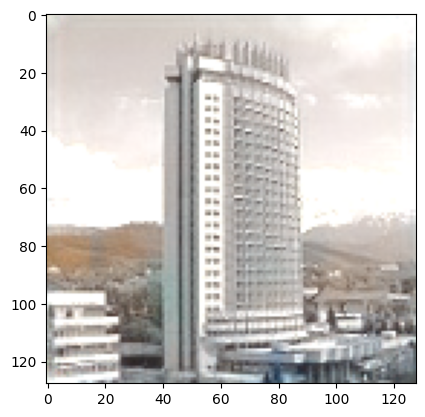

In [86]:
plt.imshow(predict.reshape(128,128,3))

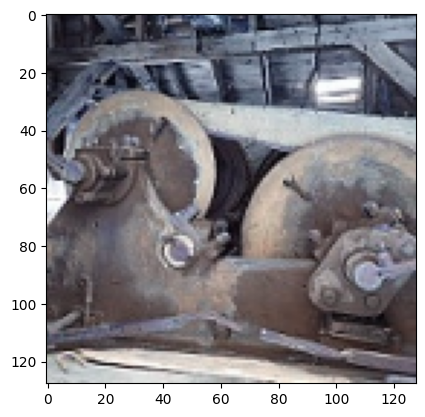

In [44]:
plt.imshow(color[1])

In [87]:
gen_model.save('genmodel_latest.h5')

In [88]:
wt=gen_model.get_weights()

In [89]:
import pickle


# Save weights to a pickle file
with open('generator_weights_2.pkl', 'wb') as f:
    pickle.dump(wt, f)

In [75]:

with open('generator_weights.pkl', 'rb') as f:
    generator_weights = pickle.load(f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


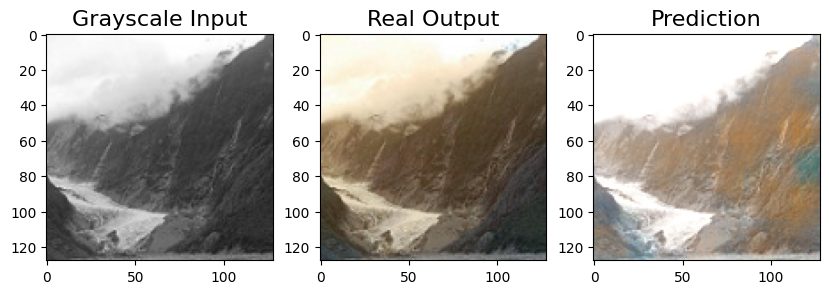

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


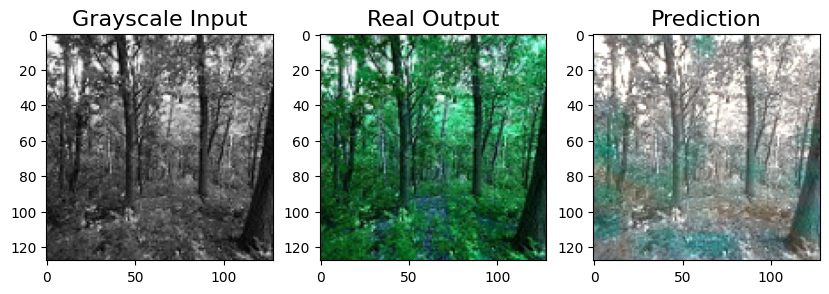

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


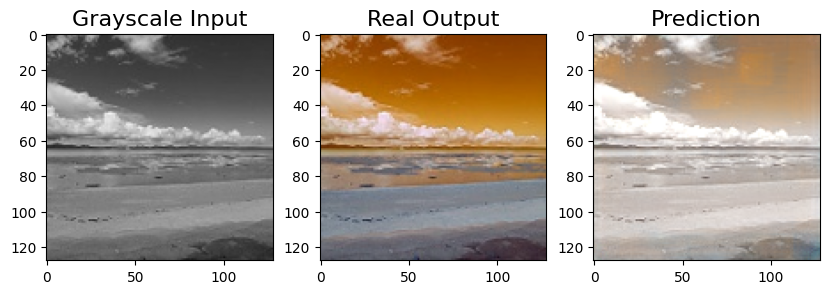

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


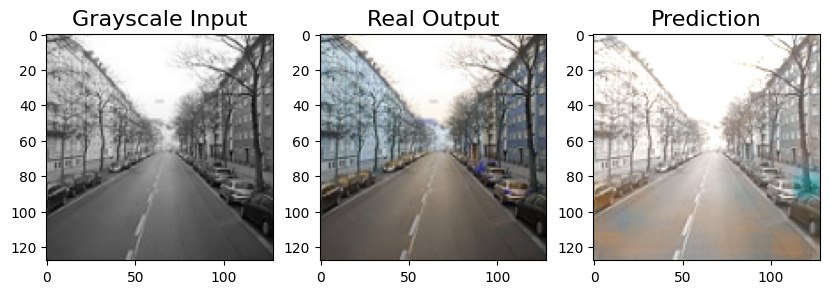

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


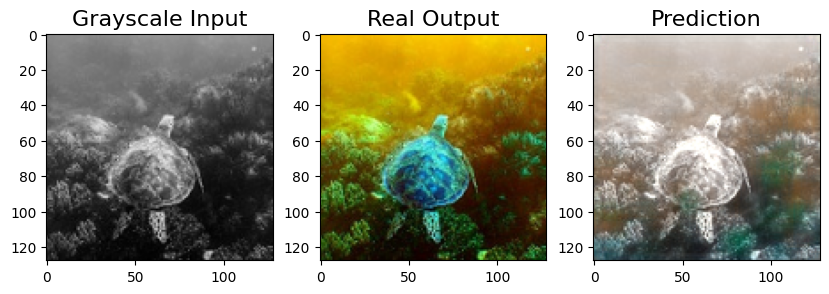

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


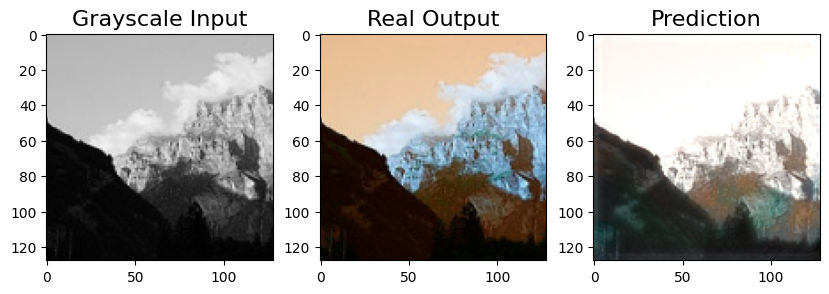

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


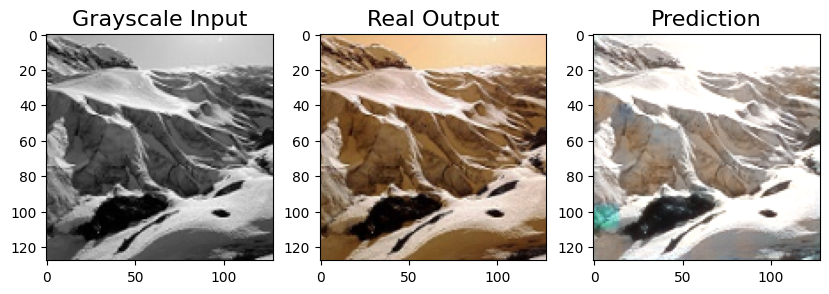

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


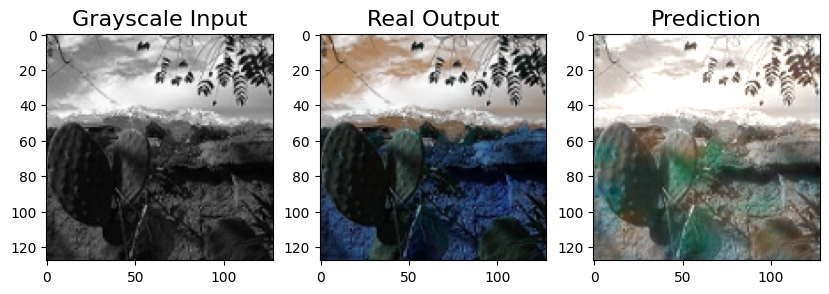

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


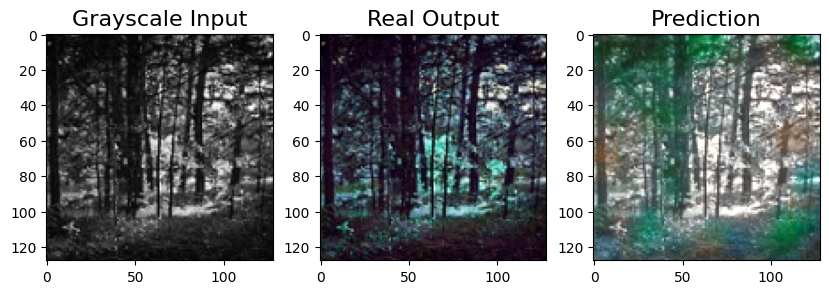

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


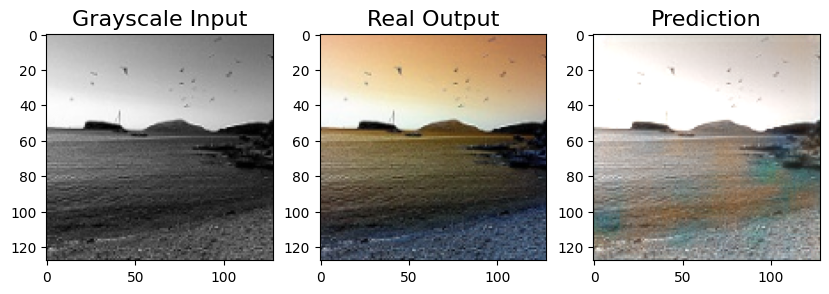

In [90]:
for i in range(20,30):
    plt.figure(figsize=(10,10))
    or_image = plt.subplot(3,3,1)
    or_image.set_title('Grayscale Input', fontsize=16)
    plt.imshow(bw[i])
    
    in_image = plt.subplot(3,3,2)
    in_image.set_title('Real Output', fontsize=16)
    plt.imshow(color[i])
    
    ou_image = plt.subplot(3,3,3)
    ou_image.set_title('Prediction', fontsize=16)
    pred = gen_model.predict(bw[i].reshape(1,128,128,3))
    plt.imshow(pred.reshape(128,128,3))
    
    plt.show()

In [79]:
print(tf.__version__)

2.15.0
